## Description:

    Which OTUs are responding to multiple treatment effects or covariates 
   


# Setting variables

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer", "VennDiagram")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.1’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’
[1] "VennDiagram"
[1] ‘1.6.17’


In [5]:
%%R
register(MulticoreParam(20))

# Read log2fold change tables

In [90]:
%%R
enzT1 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t1_sig.csv')
enzT2 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t2_sig.csv')
enzT3 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t3_sig.csv')
fertT3 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_fert_t3.csv') %>%
    filter(padj < 0.05)


l2f.hybrid = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/EarlyReleasevsYear.csv') %>%
    filter(padj < 0.05)
l2f.RYear.2 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_Year2.csv') %>%
    filter(padj < 0.05)

colnames(enzT1) %>% print
colnames(fertT3)%>% print
colnames(l2f.hybrid1939)%>% print
colnames(l2f.RYear.2) %>% print

 [1] "baseMean"       "log2FoldChange" "lfcSE"          "stat"          
 [5] "pvalue"         "padj"           "OTU"            "Rank1"         
 [9] "Rank2"          "Rank3"          "Rank4"          "Rank5"         
[13] "Rank6"          "Rank7"          "Rank8"          "test"          
 [1] "X"              "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "OTU"           
 [9] "Contrast"       "Rank1"          "Rank2"          "Rank3"         
[13] "Rank4"          "Rank5"          "Rank6"          "Rank7"         
[17] "Rank8"         
 [1] "baseMean"       "log2FoldChange" "lfcSE"          "pvalue"        
 [5] "padj"           "OTU"            "Plant"          "TimePoint"     
 [9] "Rank1"          "Rank2"          "Rank3"          "Rank4"         
[13] "Rank5"          "Rank6"          "Rank7"          "Rank8"         
 [1] "X"              "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue

## OTUs positively correlated with enzyme activity

In [16]:
%%R
enzT1$TimePoint = "T1"
enzT2$TimePoint = "T2"
enzT3$TimePoint = "T3"

In [ ]:
* Axis 1 is positively correlated with total activity at T1 and negatively correlated at T2 and T3
* Axis 2 is negatively correlated with LAP at T1, T2 and postively correlated at T3
* We are interested in all OTUs correlated as even a negative correlation indicates a shift in activity.  

In [134]:
%%R
enzT1$TimePoint = "T1"
enzT2$TimePoint = "T2"
enzT3$TimePoint = "T3"


In [135]:
%%R
Enz = bind_rows(enzT1, enzT2, enzT3)
dim(Enz)

EnzOTUs = Enz %>% select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique 
paste(EnzOTUs %>% dim %>% .[1], " OTUs correlated with changes in enzyme activity")

[1] "34  OTUs correlated with changes in enzyme activity"


## OTUs differentially abundant between early release and any other genotype 

* Currently 1939 comparison at V6 and R3 and 1936 comparison at R1

In [175]:
%%R

# l2f.hybridT2 not necessary?
HybridOTUs = l2f.hybrid %>%
#bind_rows(l2f.hybrid,  l2f.RYear.2) %>% 
        select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
        #.$OTU %>% unique
paste(HybridOTUs  %>% dim %>% .[1], " OTUs differntially abundant between genotypes")


[1] "48  OTUs differntially abundant between genotypes"


## OTUs responding to fertilizer at T3

In [93]:
%%R
FertIncrease = fertT3 %>% filter(padj < 0.05 & log2FoldChange > 0) %>% 
     select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
FertDecrease = fertT3 %>% filter(padj < 0.05 & log2FoldChange < 0) %>% 
     select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
paste(FertIncrease %>% dim %>% .[1], " OTUs enriched in fertilized rhizosphere at T3") %>% print
paste(FertDecrease %>% dim %>% .[1], " OTUs enriched in depleted in rhizosphere at T3")

[1] "88  OTUs enriched in fertilized rhizosphere at T3"
[1] "23  OTUs enriched in depleted in rhizosphere at T3"


## Rhizosphere responders

In [94]:
%%R
RhizResp = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/BarevsHybrid.csv') %>%
    filter(p.adj < 0.05 & log2FoldChange > 0) %>% 
    select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
    

paste(RhizResp %>% dim %>% .[1], " OTUs enriched in rhizosphere")


[1] "284  OTUs enriched in rhizosphere"


# Shared OTUs

In [176]:
%%R
# OTUs that are related to enzyme activity and differentially abundant between genotypes
semi_join(EnzOTUs,HybridOTUs, by = "OTU")

      OTU            Rank2                 Rank3              Rank4
1 OTU.314 __Proteobacteria __Alphaproteobacteria  __Caulobacterales
2 OTU.630 __Proteobacteria __Alphaproteobacteria __Sphingomonadales
3 OTU.311 __Actinobacteria      __Acidimicrobiia __Acidimicrobiales
                 Rank5                Rank6                  Rank7 Rank8
1   __Caulobacteraceae      __Asticcacaulis                   <NA>    NA
2 __Erythrobacteraceae __Altererythrobacter                   <NA>    NA
3          __Iamiaceae              __Iamia __uncultured_bacterium    NA


In [96]:
%%R
# OTUs that are related to enzyme activity and enriched in fertilizer treatment
semi_join(EnzOTUs,FertIncrease, by = "OTU")

      OTU            Rank2                 Rank3             Rank4
1 OTU.314 __Proteobacteria __Alphaproteobacteria __Caulobacterales
               Rank5           Rank6 Rank7 Rank8
1 __Caulobacteraceae __Asticcacaulis  <NA>    NA


In [177]:
%%R
# OTUs that are related to enzyme activity and decreased abundance in fertilizer treatment
semi_join(EnzOTUs,FertDecrease, by = "OTU")

[1] OTU   Rank2 Rank3 Rank4 Rank5 Rank6 Rank7 Rank8
<0 rows> (or 0-length row.names)


In [178]:
%%R
# OTUs differentially abundant between genotypes and enriched in fertilizer treatments
semi_join(HybridOTUs,FertIncrease, by = "OTU") %>% unique 

         OTU             Rank2                 Rank3                  Rank4
1  OTU.14139  __Proteobacteria __Alphaproteobacteria          __Rhizobiales
2    OTU.119  __Proteobacteria  __Betaproteobacteria      __Burkholderiales
3   OTU.3521  __Proteobacteria  __Betaproteobacteria      __Burkholderiales
4   OTU.4313  __Proteobacteria __Gammaproteobacteria      __Pseudomonadales
5    OTU.371 __Verrucomicrobia    __OPB35_soil_group __uncultured_bacterium
6    OTU.314  __Proteobacteria __Alphaproteobacteria      __Caulobacterales
7    OTU.357  __Proteobacteria __Gammaproteobacteria    __Enterobacteriales
8    OTU.923  __Proteobacteria __Gammaproteobacteria      __Xanthomonadales
9     OTU.93  __Proteobacteria __Gammaproteobacteria      __Xanthomonadales
10   OTU.459      __Firmicutes             __Bacilli           __Bacillales
11    OTU.80  __Actinobacteria __Propionibacteriales      __Nocardioidaceae
                      Rank5                  Rank6                     Rank7
1          

In [179]:
%%R
# OTUs differentially abundant between genotypes and depleted in fertilizer treatments
semi_join(HybridOTUs,FertDecrease, by = "OTU")

[1] OTU   Rank2 Rank3 Rank4 Rank5 Rank6 Rank7 Rank8
<0 rows> (or 0-length row.names)


** There was no overlap between OTUs depleted in fertilized plots and those OTUs correlated with enzyme activity or those differentially abundant between hybrids

# Three way venn diagram
* Enzyme OTUs
* Fertilizer OTUs
* Genotype OTUs

(polygon[GRID.polygon.170], polygon[GRID.polygon.171], polygon[GRID.polygon.172], polygon[GRID.polygon.173], polygon[GRID.polygon.174], polygon[GRID.polygon.175], text[GRID.text.176], text[GRID.text.177], text[GRID.text.178], text[GRID.text.179], text[GRID.text.180], text[GRID.text.181], text[GRID.text.182], text[GRID.text.183], text[GRID.text.184]) 


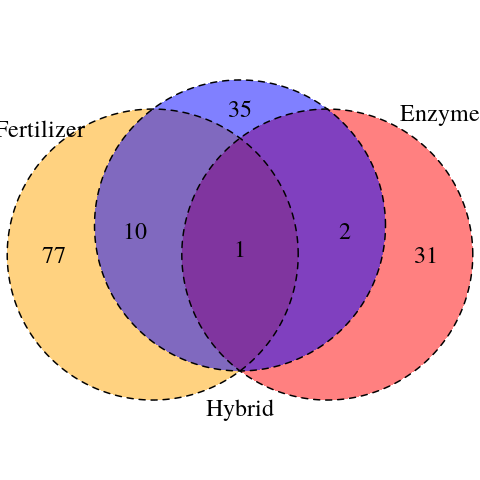

In [180]:
%%R
#area 1 = hybrid
#area 2 = Fert
#area 3 = Enzyme
draw.triple.venn(area1 = 48, area2 = 88, area3 = 34,
n12 = 11,
n23 = 1,
n13 = 3,
n123 = 1, category = c("Hybrid", "Fertilizer", "Enzyme"), lty = rep(2, 3), 
                 fill = c("blue", "orange", "red"), cex = 2,
                   cat.dist = .05, cat.cex = 2, scaled = TRUE, rotation.degree = 0, euler.d = TRUE)

* Note that there is no overlap between OTUs depleted in fertilizer treatment and either hybrids or enzymes; venn diagram only accounts for OTUs increasing in abundance

# Expore overlap betwen hybrid and fertilizer effects

In [108]:
%%R
FertIncrease

          OTU                    Rank2                  Rank3
1    OTU.2489         __Proteobacteria  __Deltaproteobacteria
2   OTU.14139         __Proteobacteria  __Alphaproteobacteria
3   OTU.15685         __Proteobacteria  __Alphaproteobacteria
4      OTU.69         __Proteobacteria  __Alphaproteobacteria
5      OTU.78         __Proteobacteria  __Alphaproteobacteria
6    OTU.3468         __Proteobacteria  __Alphaproteobacteria
7     OTU.495         __Proteobacteria  __Alphaproteobacteria
8     OTU.287          __Bacteroidetes     __Sphingobacteriia
9     OTU.267          __Bacteroidetes     __Sphingobacteriia
10    OTU.119         __Proteobacteria   __Betaproteobacteria
11   OTU.5502         __Proteobacteria   __Betaproteobacteria
12  OTU.11319         __Proteobacteria   __Betaproteobacteria
13   OTU.3521         __Proteobacteria   __Betaproteobacteria
14     OTU.11         __Proteobacteria   __Betaproteobacteria
15   OTU.5756         __Proteobacteria   __Betaproteobacteria
16     O

In [109]:
%%R
inner_join(l2f.hybrid,FertIncrease) 

     baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1    7.665748      -1.698689 0.3993900 2.107304e-05 0.024764686  OTU.3521  3517
2    9.123596      -1.644914 0.4071804 5.350445e-05 0.032784852  OTU.4313  3517
3    7.972103       2.616176 0.6373699 4.049390e-05 0.008090792   OTU.314  3517
4    5.084167       2.656703 0.6070984 1.208401e-05 0.006355854   OTU.923  3517
5   25.658440       1.502952 0.3960808 1.479053e-04 0.021224417   OTU.371  3517
6   59.221234       1.651126 0.3807162 1.445099e-05 0.008391211    OTU.80  3541
7   15.672988       2.732895 0.6408571 2.004064e-05 0.025773286 OTU.14139  3618
8  112.795336       2.697696 0.6168771 1.224662e-05 0.025773286   OTU.119  3618
9   14.281718       2.673511 0.6364114 2.658379e-05 0.025773286   OTU.357  3618
10  15.568230       2.646539 0.6318672 2.808771e-05 0.025773286   OTU.459  3618
11  87.711152       1.023373 0.2088300 9.558852e-07 0.004387513    OTU.93  3475
   TimePoint    Rank1             Rank2 

# Format tables for supplementary
* Start with hybrid effects, then add fertilizer and enzymes

In [117]:
%%R
H = l2f.hybrid %>% mutate(Test = "Hybrid") %>%
    arrange(desc(OTU)) 
colnames(H)[c(1:5,7,8,17)] = paste("hybrid", "-",colnames(H[c(1:5,7,8,17)]) )

In [155]:
%%R
F = fertT3 %>% 
    select(-X) %>% #-Rank1,-Rank2, -Rank3, -Rank4, -Rank5, -Rank6,-Rank7, -Rank8 ) %>%
    mutate(Test = "Fertilizer") %>%
    arrange(desc(OTU)) 
#colnames(F)
colnames(F)[c(1:6,8,17)] = paste("Fertilizer", "-",colnames(F[c(1:6,8,17)]) )

In [184]:
%%R

read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_fert_t3.csv') %>% 
    group_by(Contrast) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at each contrast") %>% print




[1] "33535.0243078956 normalized reads at each contrast"


In [157]:
%%R
E = Enz %>% 
   # select(-Rank1,-Rank2, -Rank3, -Rank4, -Rank5, -Rank6,-Rank7, -Rank8 ) %>%
    arrange(desc(OTU)) 

colnames(E)[c(1:6,16,17)] = paste("Enzyme", "-",colnames(E[c(1:6,8,16,17)]) )
colnames(E)

 [1] "Enzyme - baseMean"       "Enzyme - log2FoldChange"
 [3] "Enzyme - lfcSE"          "Enzyme - stat"          
 [5] "Enzyme - pvalue"         "Enzyme - padj"          
 [7] "OTU"                     "Rank1"                  
 [9] "Rank2"                   "Rank3"                  
[11] "Rank4"                   "Rank5"                  
[13] "Rank6"                   "Rank7"                  
[15] "Rank8"                   "Enzyme - Rank1"         
[17] "Enzyme - test"          


* Make enzyme axis explicit? 

In [167]:
%%R
H %>% head

  hybrid - baseMean hybrid - log2FoldChange hybrid - lfcSE hybrid - pvalue
1          2.990913                2.244707      0.6177892    2.796550e-04
2          9.298076                1.709678      0.4059691    2.538494e-05
3          3.337030               -1.662755      0.3549319    2.803505e-06
4         87.711152                1.023373      0.2088300    9.558852e-07
5          7.368062                1.888453      0.4201406    6.963110e-06
6          5.084167                2.656703      0.6070984    1.208401e-05
  hybrid - padj      OTU hybrid - Plant hybrid - TimePoint    Rank1
1   0.031212606  OTU.966           3517                 T2 Bacteria
2   0.038838954  OTU.950           3475                 T3 Bacteria
3   0.006372368  OTU.948          34M95                 T1 Bacteria
4   0.004387513   OTU.93           3475                 T3 Bacteria
5   0.031960676 OTU.9266          34M95                 T3 Bacteria
6   0.006355854  OTU.923           3517                 T2 Bacteria

In [169]:
%%R
tmp = NULL
Tbl = NULL

In [172]:
%%R
tmp = full_join(H,F, by = c("OTU",  "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7")) 

Tbl = full_join(tmp, E, by = c("OTU", "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7"))
tmp = NULL
Tbl = Tbl %>% unique
dim(Tbl) %>% print
head(Tbl) 

[1] 204  37
  hybrid - baseMean hybrid - log2FoldChange hybrid - lfcSE hybrid - pvalue
1          2.990913                2.244707      0.6177892    2.796550e-04
2          9.298076                1.709678      0.4059691    2.538494e-05
3          3.337030               -1.662755      0.3549319    2.803505e-06
4         87.711152                1.023373      0.2088300    9.558852e-07
5          7.368062                1.888453      0.4201406    6.963110e-06
6          5.084167                2.656703      0.6070984    1.208401e-05
  hybrid - padj      OTU hybrid - Plant hybrid - TimePoint  Rank1.x
1   0.031212606  OTU.966           3517                 T2 Bacteria
2   0.038838954  OTU.950           3475                 T3 Bacteria
3   0.006372368  OTU.948          34M95                 T1 Bacteria
4   0.004387513   OTU.93           3475                 T3 Bacteria
5   0.031960676 OTU.9266          34M95                 T3 Bacteria
6   0.006355854  OTU.923           3517                

In [140]:
%%R
colnames(Tbl)

 [1] "hybrid - baseMean"           "hybrid - log2FoldChange"    
 [3] "hybrid - lfcSE"              "hybrid - pvalue"            
 [5] "hybrid - padj"               "OTU"                        
 [7] "hybrid - Plant"              "hybrid - TimePoint"         
 [9] "Rank1"                       "Rank2"                      
[11] "Rank3"                       "Rank4"                      
[13] "Rank5"                       "Rank6"                      
[15] "Rank7"                       "Rank8"                      
[17] "hybrid - Test"               "Fertilizer - baseMean"      
[19] "Fertilizer - log2FoldChange" "Fertilizer - lfcSE"         
[21] "Fertilizer - stat"           "Fertilizer - pvalue"        
[23] "Fertilizer - padj"           "Fertilizer - Contrast"      
[25] "Fertilizer - Test"           "Enzyme - baseMean"          
[27] "Enzyme - log2FoldChange"     "Enzyme - lfcSE"             
[29] "Enzyme - stat"               "Enzyme - pvalue"            
[31] "Enzyme - padj"     

In [173]:
%%R
Tbl[,c(2,5, 6, 17, 19, 23, 24, 25, 27, 31, 32, 33)] %>% filter(OTU == "OTU.10")# arrange(desc(OTU)) %>% head


  hybrid - log2FoldChange hybrid - padj    OTU hybrid - Test
1                      NA            NA OTU.10          <NA>
2                      NA            NA OTU.10          <NA>
  Fertilizer - log2FoldChange Fertilizer - padj Fertilizer - Contrast  Rank1.y
1                    1.421900      4.605522e-06                  0_85 Bacteria
2                    2.325644      8.863696e-18                 0_170 Bacteria
  Fertilizer - Test Enzyme - stat Enzyme - pvalue Enzyme - padj
1        Fertilizer            NA              NA            NA
2        Fertilizer            NA              NA            NA


In [174]:
%%R
write.csv(Tbl, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/OTUIntersectionTbl.csv', row.names = FALSE)

# Loading phyloseq object

In [5]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [105]:
%%R

# Set rep and R_Year as a factor
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$R_Year = factor(sample_data(physeq.Full)$R_Year)  

#remove BARE soil controls and untreated seeds
physeq.bare = subset_samples(physeq.Full, Genotype == "Bare")
physeq.plant = subset_samples(physeq.Full, Genotype != "Bare" & SeedTreatment == "Treated")





#re-order levels 
sample_data(physeq.plant)$R_Year %>% levels


 [1] "1936" "1939" "1942" "1953" "1961" "1971" "1975" "1984" "1991" "2001"
[11] "2003" "2011"


In [108]:
%%R
physeq.bare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


# differential abundance at T3

## bare soil

In [109]:
%%R
physeq.bare.t3 = subset_samples(physeq.bare, TimePoint == "T3")

sample_data(physeq.bare.t3)$Rep = factor(sample_data(physeq.bare.t3)$Rep)
sample_data(physeq.bare.t3)$Fert = factor(sample_data(physeq.bare.t3)$Fert)

In [110]:
%%R

baredds = phyloseq_to_deseq2(physeq.bare.t3, ~ Rep + Fert)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
baredds = DESeq(baredds, fitType="local")

In [111]:
%%R
bare_res85 = results(baredds, contrast=c("Fert", "85", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
bare_res170 = results(baredds, contrast=c("Fert", "170", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)

In [112]:
%%R
summary(bare_res85)


out of 4326 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 1, 0.023% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [113]:
%%R
summary(bare_res170)


out of 4326 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [114]:
%%R
TT = tax_table(physeq.bare.t3) %>%
    as.data.frame %>%
    mutate(OTU = rownames(.))
head(TT)

     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
             Rank5           Rank6        Rank7
1 __Nannocystineae __Haliangiaceae __Haliangium
2 __Nannocystineae __Haliangiaceae __Haliangium
3 __Nannocystineae __Haliangiaceae __Haliangium
4 __Nannocystineae __Haliangiaceae __Haliangium
5 __Nannocystineae __Haliangiaceae __Haliangium
6 __Nannocystineae __Haliangiaceae __Haliangium
                               Rank8       OTU
1             __uncultured_bacterium   OTU.871
2                               <NA>  OTU.9547
3 __uncultured_delta_proteobacterium   OTU.523
4 __uncultured_delta_

In [115]:
%%R
bare_res85$OTU = rownames(bare_res85)
bare_res85$Contrast = "0_85"
bare_res170$OTU = rownames(bare_res170)
bare_res170$Contrast = "0_170"
l2f.bare.Fert = rbind(bare_res85, bare_res170) %>% as.data.frame


l2f.bare.Fert = left_join(l2f.bare.Fert, TT, by = "OTU")

In [116]:
%%R
#Number of otus depleted in fertilized plots
BareFert.sig = filter(l2f.bare.Fert, padj < 0.05)
BareFert.sig %>% filter(log2FoldChange < 0) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in bare soil fertilized plots") %>% print

#Number of otus enriched in fertilized plots that are rhizosphere repsonders at any point
BareFert.sig %>% filter(log2FoldChange > 0) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs enriched in  bare soil fertilized plots") %>% print


BareFert.sig %>% filter(log2FoldChange > 0 & OTU %in% RhizEnriched) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs enriched in  bare soil fertilized plots that are also rhizosphere responders") %>% print

# Depleted_responders = Fert.sig %>% filter(log2FoldChange < 0 & OTU %in% RhizEnriched.t1_2) 

# Depleted_responders %>% .$OTU %>% unique() %>% length %>% 
#         paste(., "OTUs depleted in fertilized plots that are also rhizosphere responders at T1 or T2") %>% print

# Depleted_responders

[1] "1 OTUs depleted in bare soil fertilized plots"
[1] "0 OTUs enriched in  bare soil fertilized plots"
[1] "0 OTUs enriched in  bare soil fertilized plots that are also rhizosphere responders"


In [117]:
%%R

BareFert.sig %>% filter(log2FoldChange < 0) 

  baseMean log2FoldChange     lfcSE      stat       pvalue      padj     OTU
1  18.6089      -1.484654 0.3366368 -4.410253 1.032499e-05 0.0446659 OTU.399
  Contrast    Rank1            Rank2                Rank3           Rank4
1     0_85 Bacteria __Proteobacteria __Betaproteobacteria __Rhodocyclales
             Rank5        Rank6                  Rank7 Rank8
1 __Rhodocyclaceae __uncultured __uncultured_bacterium  <NA>


## Rhizosphere

In [12]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
sample_data(physeq.plant.t3)$R_Year = factor(sample_data(physeq.plant.t3)$R_Year)
sample_data(physeq.plant.t3)$Genotype = factor(sample_data(physeq.plant.t3)$Genotype)
sample_data(physeq.plant.t3)$Rep = factor(sample_data(physeq.plant.t3)$Rep)
sample_data(physeq.plant.t3)$Fert = factor(sample_data(physeq.plant.t3)$Fert)

In [13]:
%%R

plantdds = phyloseq_to_deseq2(physeq.plant.t3, ~ Rep + Genotype + Fert)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
plantdds = DESeq(plantdds, fitType="local")

In [15]:
%%R
resultsNames(plantdds)

 [1] "Intercept"       "Rep1"            "Rep2"            "Rep3"           
 [5] "Rep4"            "Genotype330"     "Genotype3475"    "Genotype34M95"  
 [9] "Genotype3517"    "Genotype354"     "GenotypeP1151HR" "Fert0"          
[13] "Fert85"          "Fert170"        


In [16]:
%%R
#Function for gathering results

# get_res = function(diagdds, plant) {
#     r = results(diagdds, contrast=c("Plant", plant, "330"), independentFiltering = TRUE, parallel = TRUE)
#     #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
#     df = as.data.frame(r[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
#     df$OTU = rownames(df)
#     df$Plant = plant
    
#     return(df)
# }
res85 = results(plantdds, contrast=c("Fert", "85", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
res170 = results(plantdds, contrast=c("Fert", "170", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)

In [17]:
%%R
summary(res85)


out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 25, 0.54% 
LFC < 0 (down)   : 4, 0.087% 
outliers [1]     : 0, 0% 
low counts [2]   : 2314, 50% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [46]:
%%R
summary(res170)


out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 83, 1.8% 
LFC < 0 (down)   : 21, 0.46% 
outliers [1]     : 0, 0% 
low counts [2]   : 1424, 31% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [42]:
%%R
TT = tax_table(physeq.plant.t3) %>%
    as.data.frame %>%
    mutate(OTU = rownames(.))
head(TT)

     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
             Rank5           Rank6        Rank7
1 __Nannocystineae __Haliangiaceae __Haliangium
2 __Nannocystineae __Haliangiaceae __Haliangium
3 __Nannocystineae __Haliangiaceae __Haliangium
4 __Nannocystineae __Haliangiaceae __Haliangium
5 __Nannocystineae __Haliangiaceae __Haliangium
6 __Nannocystineae __Haliangiaceae __Haliangium
                               Rank8       OTU
1             __uncultured_bacterium   OTU.871
2                               <NA>  OTU.9547
3 __uncultured_delta_proteobacterium   OTU.523
4 __uncultured_delta_

In [43]:
%%R
res85$OTU = rownames(res85)
res85$Contrast = "0_85"
res170$OTU = rownames(res170)
res170$Contrast = "0_170"
l2f.Fert = rbind(res85, res170) %>% as.data.frame


l2f.Fert = left_join(l2f.Fert, TT, by = "OTU")

In [44]:
%%R
#df_plant.t1$p.adj = p.adjust(df_plant.t1$pvalue, "BH")
head(l2f.Fert) %>% print
tail(l2f.Fert) %>% print



    baseMean log2FoldChange     lfcSE       stat      pvalue      padj
1  7.0919597     -0.5366518 0.2066106 -2.5974072 0.009393051 0.2878374
2  0.5654074     -0.2243810 0.3850527 -0.5827281 0.560076327        NA
3 14.6904237     -0.2146339 0.1473315 -1.4568089 0.145169139 0.7854952
4  2.9451143     -0.2864698 0.2823308 -1.0146603 0.310267776 0.8813793
5  1.1655532     -0.2565499 0.3659256 -0.7010985 0.483241557        NA
6  2.4309638     -0.3636330 0.2826494 -1.2865162 0.198262978 0.8393963
        OTU Contrast    Rank1            Rank2                 Rank3
1   OTU.871     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
2  OTU.9547     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
3   OTU.523     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
4  OTU.1107     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
5 OTU.11742     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
6  OTU.1889     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
           Rank4    

In [51]:
%%R
write.csv(l2f.Fert, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_fert_t3.csv")

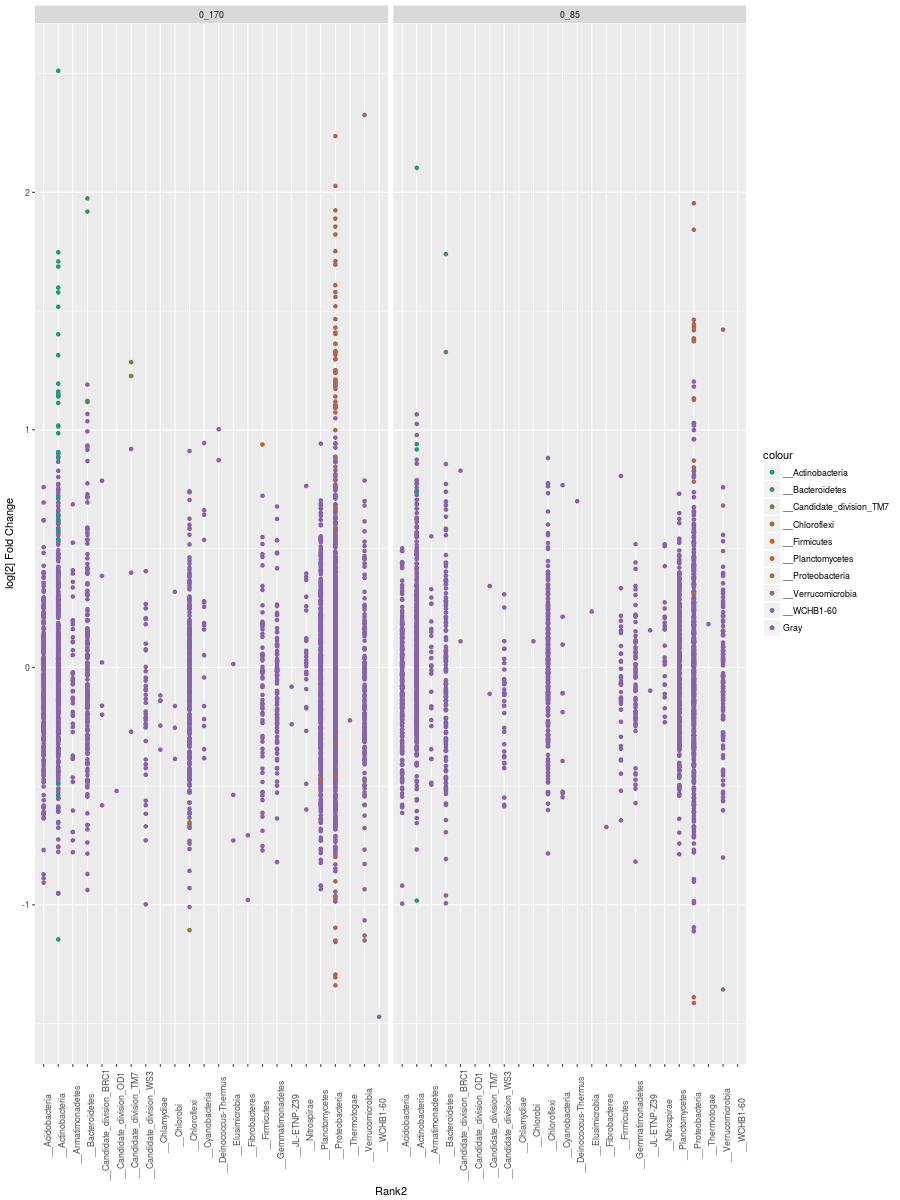

In [56]:
%%R -w 900 -h 1200
#df.adj = df_plant.t1[!is.na(df_plant.t1$padj),]

df.sig = l2f.Fert %>% filter(padj < .05)
df.ns = l2f.Fert %>% filter(padj >= .05)
colourCount = length(unique(df.sig$Rank2))
colourCount = length(unique(l2f.Fert$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(l2f.Fert)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~Contrast)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))

df.sig = NULL
df.ns = NULL
#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)
#p = p + theme_bw()




#p = p + geom_hline(y = l2fc.threshold)



#p = p + theme(axis.text.x = element_blank())

#p = p + labs(x = "Phylum", color = "Phylum")

#p = p + guides(col = guide_legend(ncol = 2))

#p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

#p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [ ]:
# Compare Fert responders to rhizosphere responders

In [55]:
%%R
l2f.rhiz = read.csv(file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/BarevsHybrid.csv", header = TRUE)

In [57]:
%%R
Fert.sig = l2f.Fert %>% filter(padj < .05)
    Fert.sig %>% head %>% print
Rhiz.sig = l2f.rhiz %>% filter(p.adj < .05)

    baseMean log2FoldChange      lfcSE     stat       pvalue        padj
1  57.336477      0.3088018 0.09036034 3.417448 6.321110e-04 0.049772638
2  31.608509      1.3851356 0.33690111 4.111401 3.932652e-05 0.005594198
3  33.698029      1.1325439 0.32376969 3.497992 4.687744e-04 0.041035789
4 175.345301      0.7820358 0.19220954 4.068663 4.728373e-05 0.006330458
5  95.511586      0.8416117 0.21868204 3.848563 1.188125e-04 0.013520866
6   6.678833      1.4443268 0.34166679 4.227296 2.365160e-05 0.004364670
        OTU Contrast    Rank1            Rank2                 Rank3
1  OTU.2489     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
2 OTU.14139     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
3 OTU.15685     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
4    OTU.69     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
5    OTU.78     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
6  OTU.3468     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
      

In [86]:
%%R
# list of OTUs enriched in the rhizosphere
RhizEnriched = filter(Rhiz.sig, log2FoldChange > 0) %>%
            .$OTU %>%
            unique()

# list of OTUs enriched in the rhizosphere at T1 or T2 so fertilizer at T3 doesn't weight
RhizEnriched.t1_2 = filter(Rhiz.sig, log2FoldChange > 0 & TimePoint %in% c("T1", "T2")) %>%
            .$OTU %>%
            unique()

length(RhizEnriched)

[1] 284


In [ ]:
## OTUs depleted in fertilized treatments

In [68]:
%%R
#Number of otus depleted in fertilized plots
Fert.sig %>% filter(log2FoldChange < 0) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in fertilized plots") %>% print

#Number of otus depleted in fertilized plots that are rhizosphere repsonders at any point
Fert.sig %>% filter(log2FoldChange < 0 & OTU %in% RhizEnriched) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in fertilized plots that are also rhizosphere responders") %>% print

Depleted_responders = Fert.sig %>% filter(log2FoldChange < 0 & OTU %in% RhizEnriched.t1_2) 

Depleted_responders %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in fertilized plots that are also rhizosphere responders at T1 or T2") %>% print

Depleted_responders

[1] "23 OTUs depleted in fertilized plots"
[1] "7 OTUs depleted in fertilized plots that are also rhizosphere responders"
[1] "4 OTUs depleted in fertilized plots that are also rhizosphere responders at T1 or T2"
  baseMean log2FoldChange     lfcSE      stat       pvalue         padj     OTU
1  9.04846     -0.9006545 0.2816683 -3.197572 1.385900e-03 0.0439099548 OTU.613
2 17.19523     -1.1293054 0.2714858 -4.159723 3.186343e-05 0.0024018958 OTU.500
3 19.06640     -0.6527816 0.2052594 -3.180277 1.471346e-03 0.0452260192 OTU.848
4 11.64357     -1.1063480 0.2329514 -4.749265 2.041573e-06 0.0002393934 OTU.400
  Contrast    Rank1             Rank2                 Rank3
1    0_170 Bacteria  __Proteobacteria __Deltaproteobacteria
2    0_170 Bacteria __Verrucomicrobia            __Opitutae
3    0_170 Bacteria     __Chloroflexi      __Chloroflexales
4    0_170 Bacteria     __Chloroflexi      __Chloroflexales
                  Rank4            Rank5                  Rank6
1        __Myxococcales

### %%R
#Number of otus enriched in fertilized plots
FertResponders = Fert.sig %>% filter(log2FoldChange > 0) %>% .$OTU %>% unique()  
FertResponders %>% length %>% paste(., "OTUs enriched in fertilized plots") %>% print

#Number of otus enriched at either fertilization level:
FertResponders = Fert.sig %>% filter(log2FoldChange > 0 & Contrast == "0_85") %>% .$OTU %>% unique()  
FertResponders %>% length %>% paste(., "OTUs enriched at 85kg N/ha fertilized plots") %>% print

FertResponders = Fert.sig %>% filter(log2FoldChange > 0 & Contrast == "0_170") %>% .$OTU %>% unique()  
FertResponders %>% length %>% paste(., "OTUs enriched at 170kg N/ha fertilized plots") %>% print

#Number of otus enriched in fertilized plots that are rhizosphere repsonders at any point
Enriched_responders = Fert.sig %>% filter(log2FoldChange > 0 & OTU %in% RhizEnriched) %>% .$OTU %>% unique()  
        paste(length(Enriched_responders), "OTUs enriched in fertilized plots that are also rhizosphere responders") %>% print

Enriched_responders.t1_2 = Fert.sig %>% filter(log2FoldChange > 0 & OTU %in% RhizEnriched.t1_2) %>% unique

Enriched_responders.t1_2 %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs enriched in fertilized plots that are also rhizosphere responders at T1 or T2") %>% print

Enriched_responders 

In [72]:
%%R
#Fertilizer responders that are not rhizosphere responders at t1 or t2:
Enriched_non_responders = Fert.sig %>% filter(log2FoldChange > 0 & !OTU %in% RhizEnriched)
Enriched_non_responders

      baseMean log2FoldChange      lfcSE     stat       pvalue         padj
1   57.3364770      0.3088018 0.09036034 3.417448 6.321110e-04 0.0497726377
2    4.6717326      1.3820479 0.36249936 3.812553 1.375389e-04 0.0149065996
3   54.3873396      0.4896057 0.13115473 3.733039 1.891835e-04 0.0187209381
4   26.5477688      0.6811600 0.17449482 3.903612 9.476769e-05 0.0113521719
5    2.9692605      1.4034086 0.31067578 4.517277 6.263991e-06 0.0006834449
6    2.7249295      1.2006362 0.35842767 3.349731 8.089017e-04 0.0304878905
7    1.5300740      1.3614809 0.36701811 3.709574 2.076083e-04 0.0109547961
8    4.9230742      1.0731758 0.30922435 3.470541 5.194110e-04 0.0210827574
9   22.3371557      0.5853601 0.18281168 3.201984 1.364845e-03 0.0439099548
10   1.6826509      1.4659428 0.38181408 3.839415 1.233276e-04 0.0072306525
11   1.3505475      1.2979404 0.36960915 3.511657 4.453232e-04 0.0193136051
12   1.2802340      1.1918366 0.36032972 3.307628 9.408975e-04 0.0342400168
13   1.04817

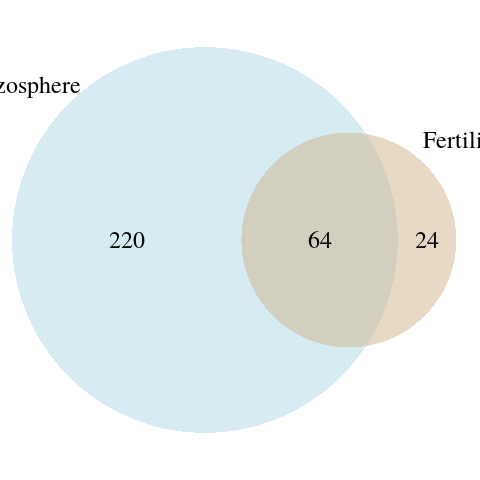

In [84]:
%%R
grid.newpage()
pV = draw.pairwise.venn(area1 = length(RhizEnriched), area2 = length(FertResponders), cross.area = length(Enriched_responders),
                   category = c("Rhizosphere", "Fertilizer"), lty = rep("blank", 2), 
                 fill = c("lightblue", "tan"), alpha = rep(0.5, 2), cex = 2,
                   cat.dist = .05, cat.cex = 2, scaled = TRUE, rotation.degree = 0) %>% grobTree

In [85]:
%%R
tiff("/home/bryan/ERA/data/figures/Rhiz_fert_venn.tiff", width = 5.18, height = 5, units = "in", res = 300)
draw.pairwise.venn(area1 = length(RhizEnriched), area2 = length(FertResponders), cross.area = length(Enriched_responders),
                   category = c("Rhizosphere", "Fertilizer"), lty = rep("blank", 2), 
                 fill = c("lightblue", "tan"), alpha = rep(0.5, 2), cex = 2,
                   cat.dist = .05, cat.cex = 2, scaled = TRUE, rotation.degree = 0)
dev.off()

png 
  2 


In [49]:
%%R
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.2 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2         vegan_2.4-3               
 [3] lattice_0.20-35            permute_0.9-4             
 [5] reshape2_1.4.2             tidyr_0.6.1               
 [7] dplyr_0.5.0                phyloseq_1.19.1           
 [9] scales_0.4.1               gridExtra_2.2.1           
[11] ggplot2_2.2.1              DESeq2_1.14.1             
[13] SummarizedExper